# Particle filtering

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

np.set_printoptions(suppress=True, precision=4)

* Recursive Bayesian filtering by MC simulations

> They key idea is to represent the required posterior density function by a set of random samples with associated weights and to compute estimates based on these samples and weights

## Importance sampling

$$
\begin{aligned}
    \mathbb{E}[g(x) \vert {\bf y}] &\approx \frac{1}{N}\sum_{n=1}^N \frac{p(x^{(i)} \vert {\bf y})}{\pi(x^{(i)} \vert {\bf y})} g(x^{(i)} \vert {\bf y})\\
    &= \sum_{n=1}^N \tilde w^{(i)} g(x^{(i)} \vert {\bf y}),
\end{aligned}
$$

where 
$$
    \tilde w^{(i)} = \frac{p(x^{(i)} \vert {\bf y})}{N \pi(x^{(i)} \vert {\bf y})}
$$

In [4]:
# importance distribution
pi_dist = norm(0, 2)
# target distribution
p_dist = t(4, 0)

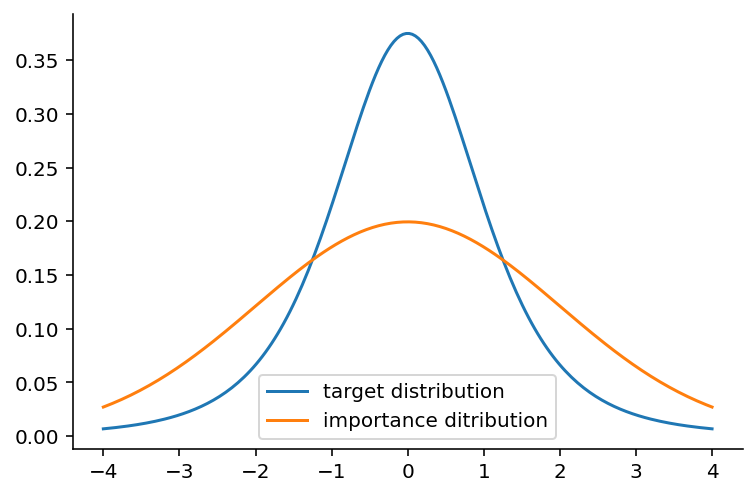

In [5]:
xrange = np.linspace(-4, 4, 200)
plt.plot(xrange, p_dist.pdf(xrange), label="target distribution")
plt.plot(xrange, pi_dist.pdf(xrange), label="importance ditribution")
plt.legend()

In [6]:
np.random.seed(314)
N = 100
# samples from the importance distribution
x_rvs = pi_dist.rvs(N)
# Samples from the target distribution
p_rvs = p_dist.rvs(N)

In [7]:
weights = p_dist.pdf(x_rvs) / (N * pi_dist.pdf(x_rvs))

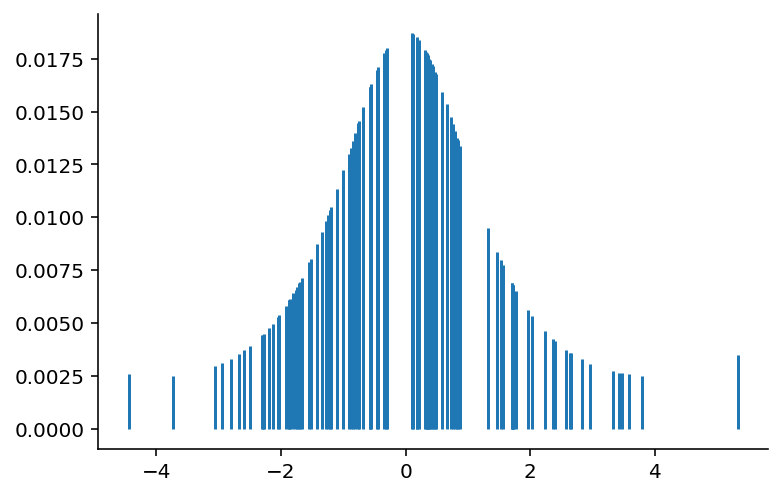

In [8]:
for xi, wi in zip(x_rvs, weights):
    plt.vlines(xi, 0, wi)

In [9]:
def g(x): return x ** 2

In [10]:
(weights * g(x_rvs)).sum()

1.6542189530195281

In [11]:
g(p_rvs).mean()

2.0109239264713437

> The disadvantage of direct importance sampling is that we should be able to evaluate $p(x^{(i)} \vert {\bf y})$ in order to use it directly.

That is, we need to compute
$$
    p(x^{(i)} \vert {\bf y}) = \frac{p(x^{(i)}) p({\bf y} \vert x^{(i)})}{\int p(x) p({\bf y} \vert x) dx},
$$

where the marginal likelihood may be difficult to compute.

## The Bootstrap filter

In [49]:
import jax
import jax.numpy as jnp
import nlds_lib as ds
from jax import random
from jax.scipy import stats
from jax.ops import index_update

1. Draw a new point ${\bf z}_t^{(n)}$ for each point in the sample set $\{{\bf z}_{t-1}^{(n)}\}_{n=1}^N$ from the model

$$
    {\bf z}_{t}^{(n)} \vert {\bf z}_{t-1}^{(n)} \sim p({\bf z}_t \vert {\bf z}_{t-1}^{(n)}) \ \forall n=1,\ldots,N
$$

2. Calculate the weights
$$
    w_{k}^{(n)} \propto p({\bf x}_t \vert {\bf z}_t^{(n)}) \forall n=1,\ldots,N,
$$
and normalize them to sum to unity

3. Do resampling

### Example

Suppose

$$
\begin{aligned}
    {\bf z}_t \vert {\bf z}_{t-1} &\sim \mathcal{N}(f_z({\bf z}_{t-1}), {\bf Q})\\
    {\bf x}_t \vert {\bf z}_{t} &\sim \mathcal{N}(f_x({\bf z}_{t}), {\bf R}) 
\end{aligned}
$$

In [12]:
def plot_samples(sample_state, sample_obs):
    fig, ax = plt.subplots()
    ax.plot(*sample_state.T, label="state space")
    ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")
    ax.scatter(*sample_state[0], c="black", zorder=3)
    ax.legend()
    ax.set_title("Noisy observations from hidden trajectory")
    plt.axis("equal")

In [51]:
def fz(x, dt): return x + dt * jnp.array([jnp.sin(x[1]), jnp.cos(x[0])])
def fx(x): return x

In [52]:
dt = 0.4
nsteps = 100
# Initial state vector
x0 = jnp.array([1.5, 0.0])
# State noise
Qt = jnp.eye(2) * 0.001
# Observed noise
Rt = jnp.eye(2) * 0.05
alpha, beta, kappa = 1, 0, 2

key = random.PRNGKey(314)
model = ds.NLDS(lambda x: fz(x, dt), fx, Qt, Rt)
sample_state, sample_obs = model.sample(key, x0, nsteps)

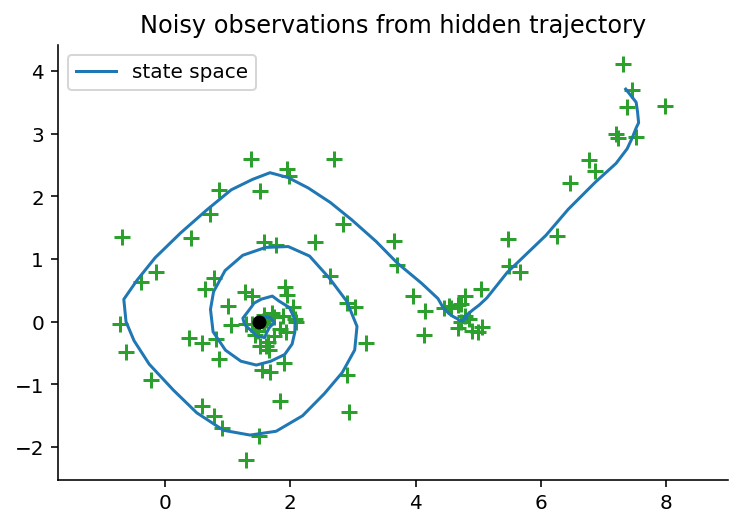

In [50]:
plot_samples(sample_state, sample_obs)

In [137]:
nsamples = 2000

#### First step

In [138]:
zt_rvs = random.multivariate_normal(keys[0], x0, Qt, (nsamples,))
xt_rvs = random.multivariate_normal(keys[0], fx(zt_rvs), Rt)

In [139]:
weights_t = stats.multivariate_normal.pdf(sample_obs[0], xt_rvs, Qt)
weights_t = weights_t / weights_t.sum()
weights_t.sum()

DeviceArray(1., dtype=float32)

In [140]:
mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
mu_t

DeviceArray([1.5   , 0.0004], dtype=float32)

#### Second step

In [141]:
fz_samples = jax.vmap(fz, in_axes=(0, None))

In [142]:
zt_rvs = random.multivariate_normal(keys[1], fz_samples(zt_rvs, dt), Qt)
xt_rvs = random.multivariate_normal(keys[1], fx(zt_rvs), Rt)

In [143]:
weights_t = stats.multivariate_normal.pdf(sample_obs[1], xt_rvs, Qt)
weights_t = weights_t / weights_t.sum()
weights_t.sum()

DeviceArray(1., dtype=float32)

In [144]:
mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
mu_t

DeviceArray([ 1.5332, -0.0057], dtype=float32)

### All together

In [145]:
mu_hist = jnp.zeros((nsteps, 2))

for t, key_t in enumerate(keys):
    if t == 0:
        zt_rvs = random.multivariate_normal(key_t, x0, Qt, (nsamples,))
    else:
        zt_rvs = random.multivariate_normal(key_t, fz_samples(zt_rvs, dt), Qt)
        
    xt_rvs = random.multivariate_normal(key_t, fx(zt_rvs), Rt)
    
    weights_t = stats.multivariate_normal.pdf(sample_obs[t], xt_rvs, Qt)
    weights_t = weights_t / weights_t.sum()
    
    mu_t = (zt_rvs * weights_t[:, None]).sum(axis=0)
    mu_hist = index_update(mu_hist, t, mu_t)

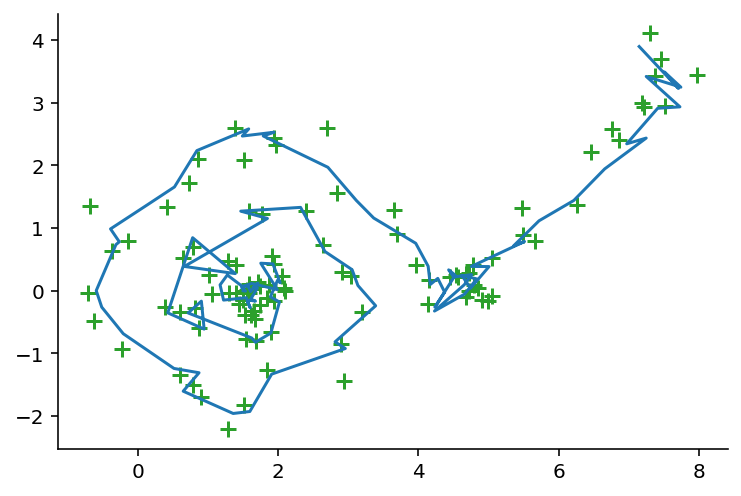

In [149]:
fig, ax = plt.subplots()
ax.plot(*mu_hist.T)
ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")

## References
1. Bayesian Filtering and Smoothing - Simo Särkkä